## ddqc Tutorial
First, lets set up the workspace loading the ddqc and pegasus packages

In [1]:
import pegasus as pg
import ddqc

### Reading the data
For this tutorial we will use the Human Bone Marrow dataset provided by pegasus. <br>
We will download the dataset using the following command:

In [2]:
!wget https://storage.googleapis.com/terra-featured-workspaces/Cumulus/MantonBM_nonmix_subset.zarr.zip -O MantonBM_nonmix_subset.zarr.zip

--2023-02-15 14:43:27--  https://storage.googleapis.com/terra-featured-workspaces/Cumulus/MantonBM_nonmix_subset.zarr.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4005:806::2010, 2607:f8b0:4005:80f::2010, 2607:f8b0:4005:80e::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4005:806::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81990995 (78M) [application/zip]
Saving to: ‘MantonBM_nonmix_subset.zarr.zip’

MantonBM_nonmix_sub 100%[===================>]  78.19M  31.6MB/s    in 2.5s    

2023-02-15 14:43:30 (31.6 MB/s) - ‘MantonBM_nonmix_subset.zarr.zip’ saved [81990995/81990995]



We will first load the data using the standard `read_input` pegasus function.

In [3]:
data = pg.read_input("MantonBM_nonmix_subset.zarr.zip")
data

2023-02-15 14:43:32,119 - pegasusio.readwrite - INFO - zarr file 'MantonBM_nonmix_subset.zarr.zip' is loaded.
2023-02-15 14:43:32,120 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.23s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 48219 x 36601
    UID: GRCh38-rna; Genome: GRCh38; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'Channel', 'gender'
    var: 'featureid'
    uns: 'genome', 'modality', 'uid'

### Biology-centered data-driven quality control (ddqc)
ddqc does adaptive quality control by clustering cells and picking a separate threshold for each cluster. It is described down below:
- Initial Qualtity Control (QC) is performed, when obvious low-quality cells are removed. By default those are cells with n_genes < 100 and percent_mito > 80.
- The cells are clustered with the clustering resolution 1.3 (default)
- Then thesholds are picked for each cluster. By default the following metrics are considered:
    - **Number of counts/UMIs**: keep cells that have n_counts greater than median - 2 Median Absolute Deviations (MAD)
    - **Number of genes**: keep cells that have n_genes greater than median - 2 MADs
    - **Percent of mitochondrial transctipts**: keep cells that have percent_mito less than median + 2 MADs
- In order to prevent the removal of healthy cells in clusters with high median n_genes and low percent_mito there are additional bounds for those thresholds:
    - Cluster-level threshold for n_genes can't be greater than 200 (default). If it is greater, it will be set to 200.
    - Cluster-level threshold for percent_mito can't be lower than 10 (default). If it is lower, it will be set to 10.

To perform ddqc on a dataset, we will run the `ddqc_metrics` function. 

If you want to customize the filtering you can use the following parameters:
- `res` (float): clustering resolution (default is 1.3).
- `clustering_method` (str): clustering method that will be used by ddqc clustering. Supported options are:
    "louvain", "leiden", "spectral_louvain", and "spectral_leiden" (default is "louvain").
- `n_components` (int): number of PCA components (default is 50).
- `k` (int): k to be used by `neighbors` Pegasus function (default is 20).
- `method` (str): statistic on which the threshold would be calculated. Supported options are "mad" and "outlier"
    (default is "mad").
- `threshold` (float): parameter for the selected method (default is 2).
    Note that "outlier" method doesn't requre parameter and will ignore this option.
- `threshold_counts` (int, None): setting for applying ddqc based on number of counts. (Default is 0)
    - If set to 0, will perform ddqc on number of counts using the `threshold` parameter provided earlier.
    - If set to a number other than 0, will  overwrite `threshold` parameter for number of counts.
    - If set to None, won't perform ddqc on number of counts.
- `threshold_genes` (int, None): Same as above, but for number of genes.
- `threshold_mito` (float, None): Same as above, but for percent of mitochondrial transcripts.
- `threshold_ribo` (float, None): Same as above, but for percent of ribosomal transcripts.
- `basic_n_counts` (int): parameter for the initial QC n_counts filtering (default is 0).
- `basic_n_genes` (int): parameter for the initial QC n_genes filtering (default is 100).
- `basic_percent_mito` (float): parameter for the initial QC percent_mito filtering (default is 80.0).
- `mito_prefix` (str): gene prefix used to calculate percent_mito in a cell (default is "MT-").
- `ribo_prefix` (str): gene regular expression used to calculate percent_ribo in a cell
    (default is "^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA").
- `n_genes_lower_bound` (int): bound for lower n_genes cluster-level threshold (default is 200).
- `percent_mito_upper_bound` (float): bound for upper percent_mito cluster-level threshold (default is 10).
- `random_state` (int): random seed for clustering results reproducibility (default is 29)
- `return_df_qc` (bool): whether to return a dataframe with the information about on what metric and what threshold
    the cell was removed for each removed cell. (default is False)
- `display_plots` (bool): whether to show plots that would show filtering statistics (default is True).

We will now run ddqc on the dataset with default settings.

/home/malperovich/Documents/code/primes/ddqc/ddqc/utils.py:18: FutureWarning: Possible nested set at position 8
  data.obs["percent_ribo"] = (data.X[:, ribo_genes].sum(axis=1).A1 / np.maximum(data.obs["n_counts"].values,
/home/malperovich/Documents/code/primes/ddqc/ddqc/utils.py:18: FutureWarning: Possible nested set at position 25
  data.obs["percent_ribo"] = (data.X[:, ribo_genes].sum(axis=1).A1 / np.maximum(data.obs["n_counts"].values,


2023-02-15 14:43:35,695 - pegasusio.qc_utils - INFO - After filtration, 48210 out of 48219 cell barcodes are kept in UnimodalData object GRCh38-rna.
2023-02-15 14:43:35,695 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.17s.
2023-02-15 14:43:36,027 - pegasus.tools.preprocessing - INFO - After filtration, 25910/36601 genes are kept. Among 25910 genes, 16967 genes are robust.
2023-02-15 14:43:36,027 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.33s.
2023-02-15 14:43:36,417 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.39s.
2023-02-15 14:43:36,484 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.07s.
2023-02-15 14:43:36,504 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2023-02-15 14:43:36,505 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.09s.
2023-02-15 14:43:40,531 -

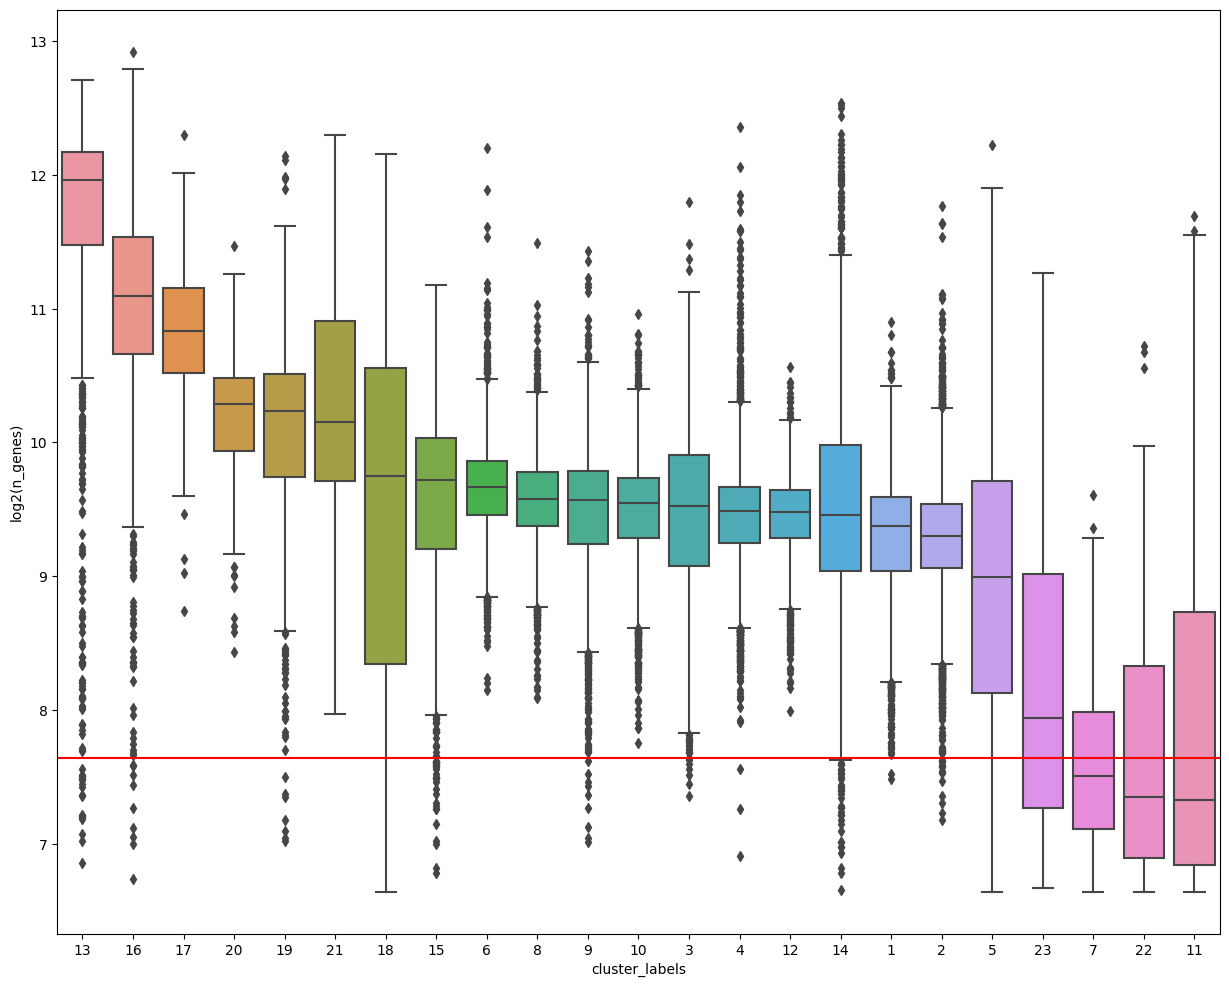

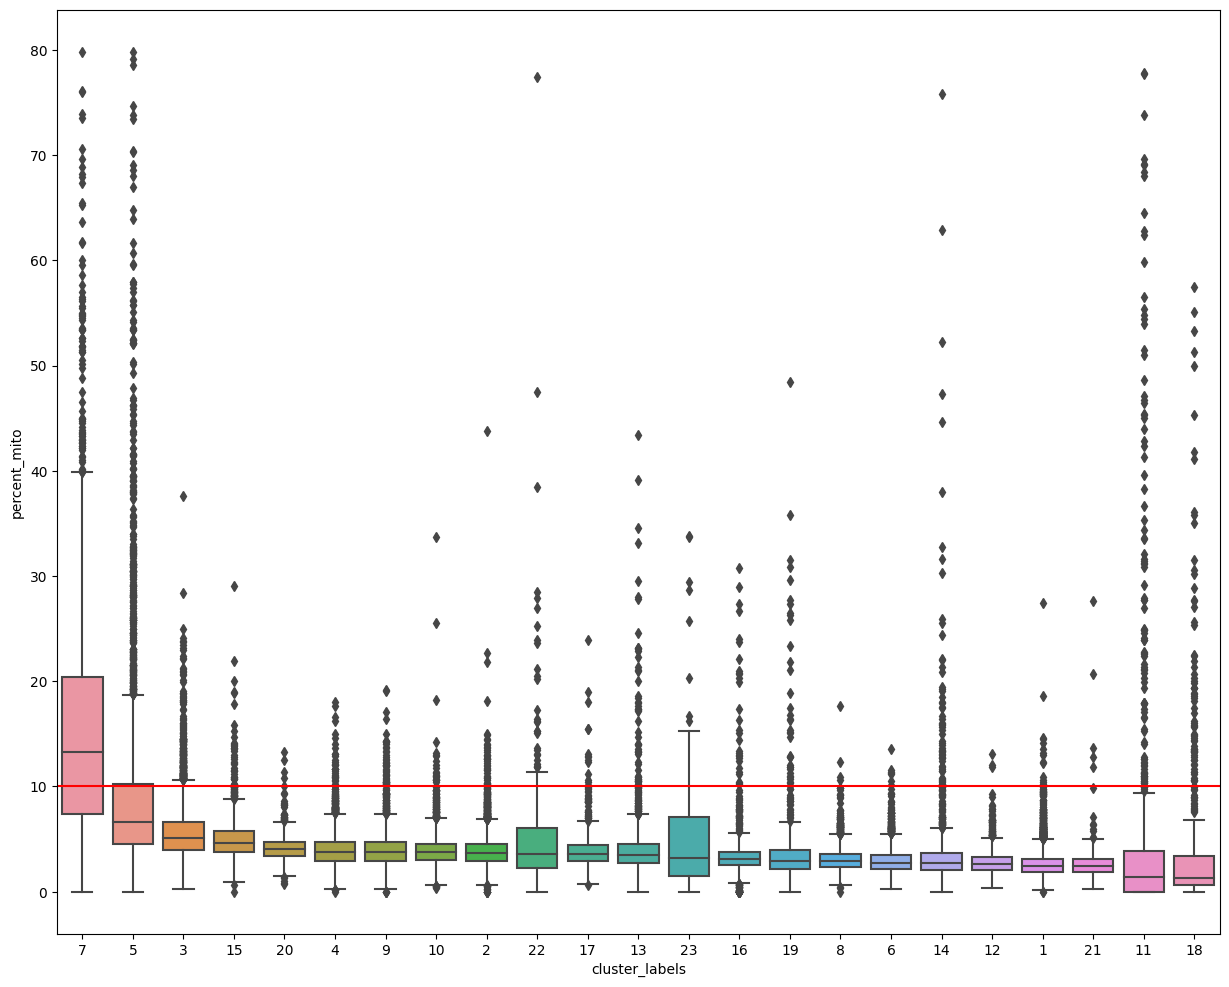

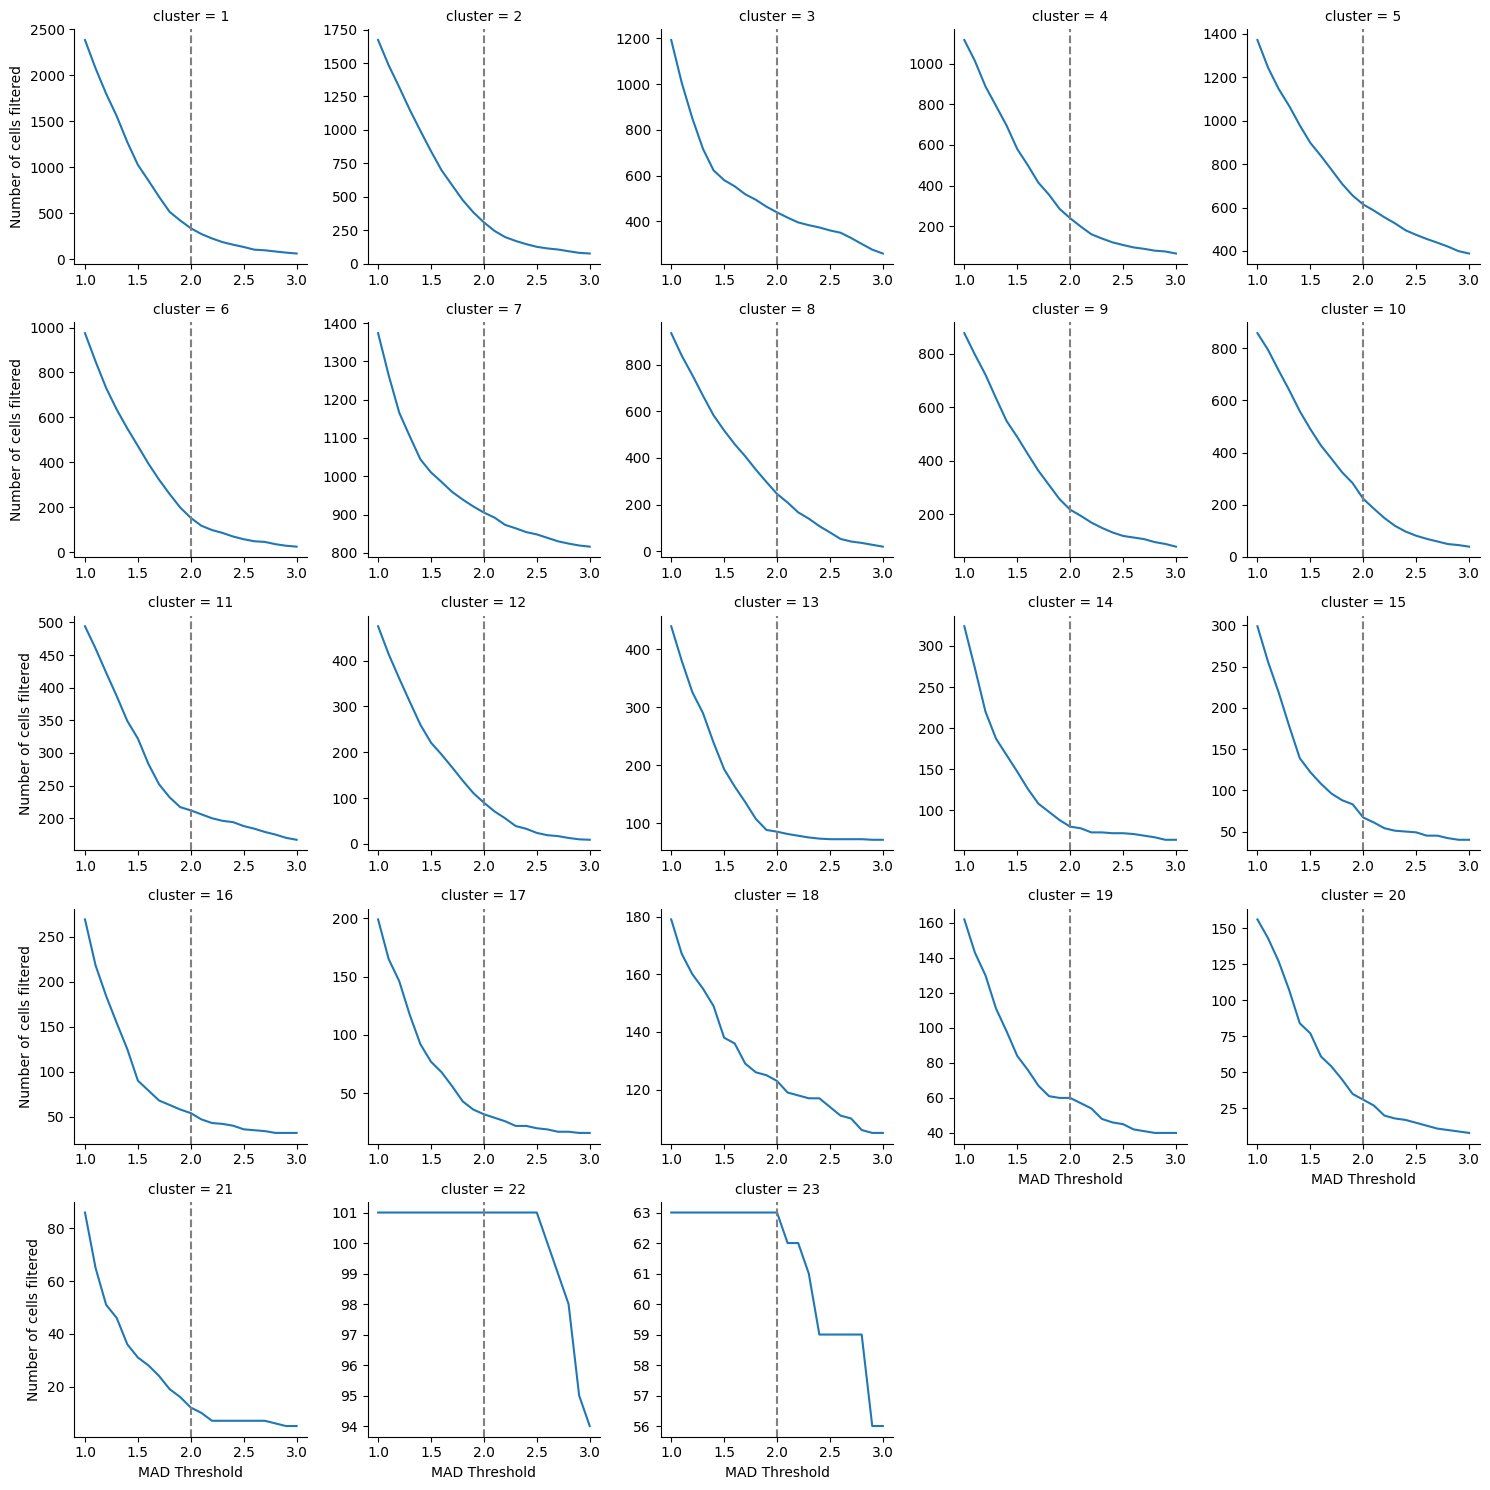

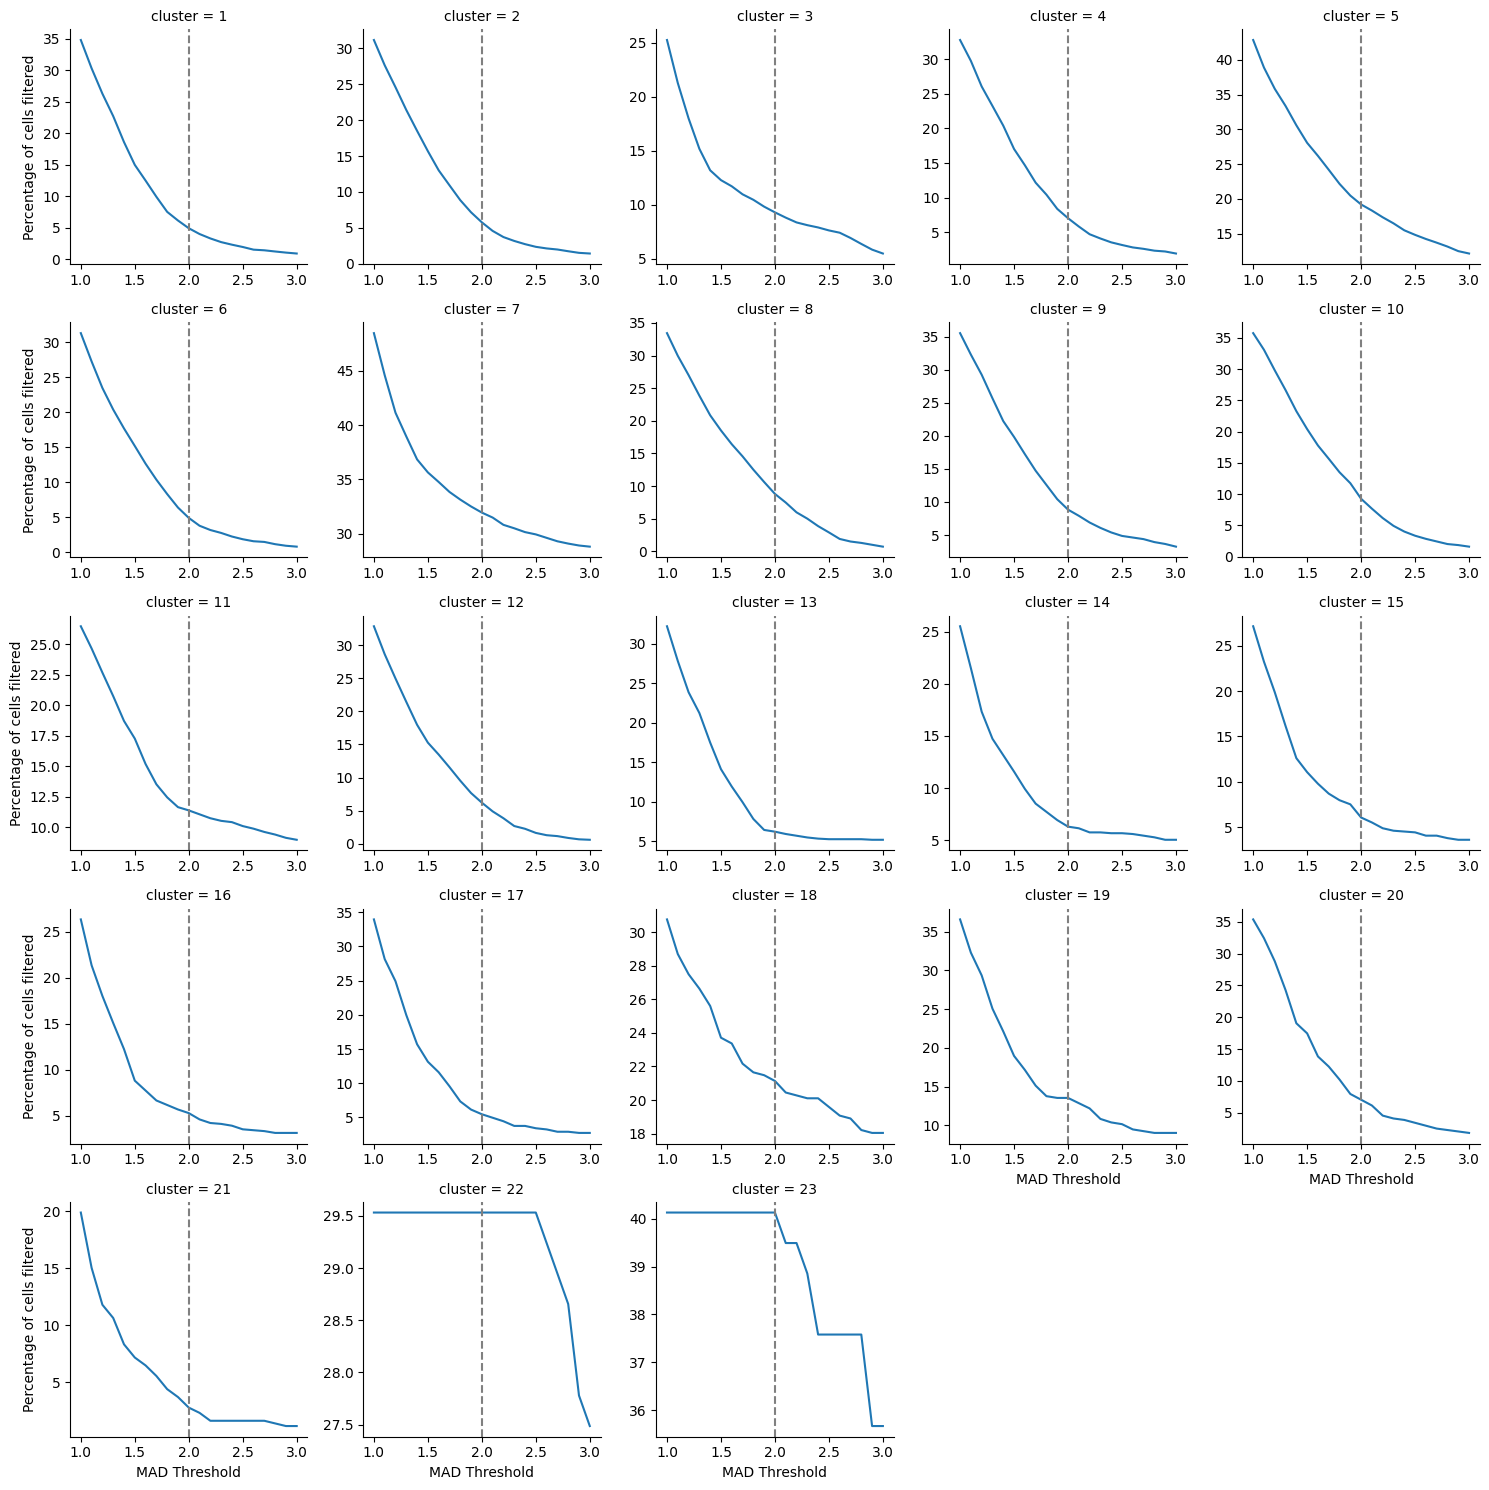

ValueError: Length of values (48210) does not match length of index (48219)

In [4]:
df_qc = ddqc.ddqc_metrics(data, return_df_qc=True)

### Disabling Initial QC
If want to use a separate QC tool instead of inital QC, such as EmptyDrops, you can disable Initial QC. Use the parameter settins outlined below (you can use these alongside any other customization parameters):

`df_qc = ddqc.ddqc_metrics(data, basic_n_counts=0, basic_n_genes=0, basic_percent_mito=100)`

### Outputs
There are four plots provided for exploratory data analysis:

The first two plots are boxplots:
- log2(n_genes) by cluster: shows log2 of number of genes for each cluster in the initial clustering. Red line at 200 genes (7.64 in log2 scale) represents the most common fixed threshold cutoff for n_genes.
- percent_mito by cluster: shows percent_mito for each cluster in the initial clustering. Red line at 10% represents the most common fixed threshold cutoff for percent_mito.

If you are using "mad" method and didn't use any of metric threshold overwrites (threshold_counts, threshold_genes, threshold_mito, threshold_ribo), ddqc will generate two facet plots that show how number of cells that are filtered out changes depending on the threshold value. These plots will help you to pick a threshold parameter if you want to tune it.

Each of those plots is faceted by cluster, and has a threshold parameter (from 1 to 3) on x-axis. First plot will have a number of cells filtered out in cluster on y-axis, second plot will have a percentage of cells filtered out in cluster.

The filtering will still be performed based on the threshold you picked.

If you requested to return df_qc the function will return a pandas dataframe containing the following info for each cell:
- `metric`: QC metric number
- `cluster_labels`: cluster from initial clustering performed by ddqc
- `metric_lower_co` and `metric_upper_co`: lower and upper cuttofs for each metric on which ddqc was performed. If ddqc was not performed for upper or lower end of this metric this field will be `None`
- `metric.passed.qc`: whether the cell passed qc for a given metric
This information is useful if you want to understand based on which metric the cell was filtered out.

In [ ]:
df_qc

### Filter out the cells
Now, we will filter out the cells that failed ddqc. Here, we started with 48219 cells and retain 45939 cells.

In [ ]:
pg.filter_data(data)

### Save the dataset
We will save the dataset as data.h5ad, which can then be imported into the scRNAseq pipeline of your choice for downstream analysis.

In [ ]:
pg.write_output(data, "data.h5ad")